# Тетрадь 7: Линейная регрессия

## Содержание

- [Введение](#Ввдение)
- [Код и примеры](#Код-и-примеры)
- [Задание](#Задание)

***

## Введение

Линейная регрессия — это один из самых простых и популярных методов машинного обучения, который
используется для моделирования линейной связи между независимыми переменными (признаками) и
целевой переменной (меткой). Основная идея заключается в том, чтобы найти такие коэффициенты (веса)
для независимых переменных, которые минимизируют ошибку предсказания целевой переменной.

### Математическая модель

Алгоритмы регрессии, такие как линейная регрессия, основаны на математической концепции
**минимизации функции ошибки** (или функции потерь). Цель регрессии — найти такие параметры модели,
которые минимизируют разницу между предсказанными значениями и реальными значениями метки. Давайте
разберем эту концепцию подробнее.

### 1. Линейная модель
Линейная регрессия предполагает, что зависимость между признаками $X$ и зависимой переменной $y$
может быть выражена линейной функцией:

$$y = w_0 + w_1 x_1 + w_2 x_2 + \dots + w_n x_n + \epsilon $$

Где:
- $y$ — целевая переменная (значение, которое мы хотим предсказать),
- $x_1, x_2, \dots, x_n$ — независимые переменные (признаки),
- $w_0$ — свободный член (bias),
- $w_1, w_2, \dots, w_n$ — коэффициенты (веса) модели,
- $\epsilon$ — ошибка (шум), которая возникает из-за случайных факторов.

### 2. Функция ошибки (Loss Function)
Для оценки качества модели используется функция потери. В случае линейной регрессии чаще всего
используется **среднеквадратичная ошибка (MSE, Mean Squared Error)**:

$$ \text{MSE}(y, \hat{y}) = \frac{1}{N} \sum_{i=1}^{N} (y_i - \hat{y}_i)^2 $$

где:
- $N$ — количество наблюдений,
- $y_i$ — реальное значение целевой переменной для $i$-го наблюдения,
- $\hat{y}_i$ — предсказанное значение для $i$-го наблюдения.

Цель модели — найти такие коэффициенты $w_0, w_1, \dots, w_n$, чтобы минимизировать MSE.

### 3. Градиентный спуск (Gradient Descent)
Для минимизации функции ошибки используется метод **градиентного спуска**. Градиентный спуск — это
итеративный алгоритм оптимизации, который шаг за шагом корректирует коэффициенты модели, чтобы
уменьшить потерю.

#### Шаги градиентного спуска:
1. **Инициализация коэффициентов**. Начинаем с произвольных значений коэффициентов 
$w_0, w_1, \dots, w_n$.

2. **Вычисление градиента**. Градиент функции ошибки — это вектор частных производных по каждому
коэффициенту. Для MSE градиент вычисляется как:
   $$
   \frac{\partial \text{MSE}(y, \hat{y})}{\partial w_j} =
   -\frac{2}{N} \sum_{i=1}^{N} x_{ij} (y_i - \hat{y}_i),
   $$
   где $x_{ij}$ — значение $j$-го признака для $i$-го наблюдения.

3. **Обновление коэффициентов**. Коэффициенты обновляются по формуле:
   $$
   w_j = w_j - r \cdot \frac{\partial \text{MSE}(y, \hat{y})}{\partial w_j},
   $$
   где $r$ — скорость обучения (learning rate), которая определяет размер шага.

4. **Повторение**. Шаги 2 и 3 повторяются до тех пор, пока ошибка не станет достаточно малой или
пока не будет достигнуто максимальное число итераций.

### 4. Регуляризация
В некоторых случаях модель может переобучаться, то есть слишком точно подстраиваться под обучающие
данные, что ухудшает её обобщающую способность. Для борьбы с переобучением используются методы
регуляризации:
- **L2-регуляризация (Ридж-регрессия)**. Добавляет штраф за большие значения коэффициентов:
   $$
   \text{Loss}(y, \hat{y}) = \text{MSE}(y, \hat{y}) + p \sum_{j=1}^{n} w^2,
   $$
   где $p$ — параметр регуляризации.
- **L1-регуляризация (Лассо-регрессия)**. Добавляет штраф за абсолютные значения коэффициентов:
   $$
   \text{Loss}(y, \hat{y}) = \text{MSE}(y, \hat{y}) + p \sum_{j=1}^{n} |w_j|
   $$
   L1-регуляризация может обнулять некоторые коэффициенты, что полезно для отбора признаков.

***

## Код и примеры

In [6]:
from abc import ABC, abstractmethod
from typing import Any, Dict, Optional, Tuple, Union
from zipfile import ZipFile

import matplotlib.pyplot as plt
import numpy as np
from numpy import ndarray
from pandas import read_csv

from modules.metrics import (
    compute_mean_absolute_error,
    compute_mean_squared_error,
)
from modules.models import ModelBase
from modules.preprocessing import DataSplitter, MMScalingPreprocessor


SamplesBatch = Tuple[ndarray, ndarray]
WeightsMap = Dict[str, Union[ndarray, float]]
ComputationalMetadata = Dict[str, Union[Dict[str, ndarray], WeightsMap, float]]


def unzip(file_path: str, extract_to: str) -> None:
    with ZipFile(file_path, "r") as zip_ref:
        zip_ref.extractall(extract_to)


def visualize_mean_absolute_error(
    title: str, actual: ndarray, predicted: ndarray
) -> None:
    figure, axis = plt.subplots()
    max_value = np.max(np.concatenate([actual, predicted]))
    limit = int((max_value + 10) - (max_value % 10))
    diagonal = list(range(limit))
    colors = np.array(
        [
            compute_mean_absolute_error(fact, pred)
            for fact, pred in zip(actual, predicted)
        ]
    )

    axis.set_xlim(0, limit)
    axis.set_ylim(0, limit)
    axis.set_xlabel("Actual")
    axis.set_ylabel("Predicted")
    _ = axis.plot(diagonal, diagonal, linestyle="--", color="purple")
    scatter_plot = axis.scatter(actual, predicted, c=colors, cmap="RdBu")
    axis.set_title(title, fontsize=14)
    figure.colorbar(scatter_plot, label="MAE value")

    plt.tight_layout()
    plt.show()

### Простая линейная регрессия

Ниже приведен пример класса `SimpleLinearRegression`, который реализует простую линейную регрессию
путем подбора коэффициентов с некоторым шагом. Этот класс наследует абстрактный базовый
`ModelBase`, с которым мы уже хорошо знакомы.

In [7]:
class SimpleLinearRegression(ModelBase):
    """Simple linear regression model that guesses the linear relationship
    by adjusting coefficients with a certain step.
    """

    def __init__(
        self,
    ) -> ndarray:
        super().__init__()

    def fit(
        self,
        x_train: ndarray,
        y_train: ndarray,
        *args,
        learning_rate: float = 0.01,
        n_iterations: int = 1000,
        **kwargs,
    ) -> None:
        """Fit the model to the training data."""
        super().fit(x_train, y_train, *args, **kwargs)
        n_samples, n_features = x_train.shape
        # + 1 for bias term.
        self.weights_map_ = np.zeros(n_features + 1)

        # Add bias term to `x_train`.
        x_train = np.c_[x_train, np.ones(n_samples)]

        # Gradient descent.
        for _ in range(n_iterations):
            predictions = np.dot(x_train, self.weights_map_)
            errors = predictions - y_train
            gradients = np.dot(x_train.T, errors) / n_samples
            self.weights_map_ -= np.mean(
                learning_rate * gradients, axis=1
            )

    def predict(self, x_test: ndarray) -> ndarray:
        """Predict the target variable for the test data."""
        # Add bias term to `x_test`.
        x_test = np.c_[x_test, np.ones(x_test.shape[0])]
        return np.dot(x_test, self.weights_map_)

Проверим работоспособность нашей модели на случайных данных.

MAE: 0.10997603723477557


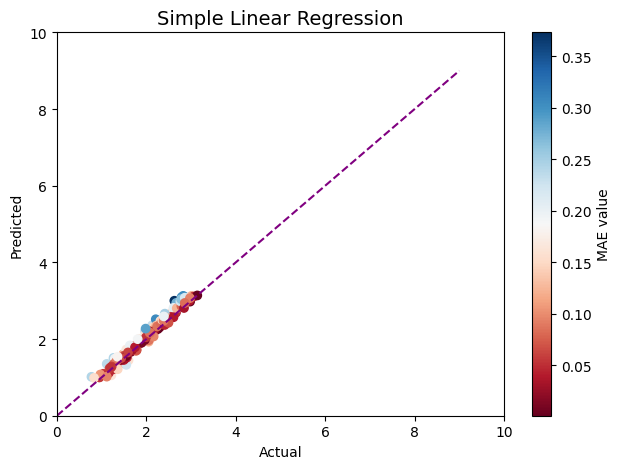

In [55]:
x_rand = np.random.rand(1000, 1)
y_rand = 2 * x_rand + 1 + 0.1 * np.random.randn(1000, 1)

splitter = DataSplitter(permute=True)
x_train, x_test, y_train, y_test = splitter.split_data(
    x_rand, y_rand, test_size=0.15
)

model = SimpleLinearRegression()
model.fit(x_train, y_train, learning_rate=0.1, n_iterations=1000)

y_predicted = model.predict(x_test).reshape((-1, 1))
mae = compute_mean_absolute_error(y_test, y_predicted)
print("MAE:", mae)
visualize_mean_absolute_error("Simple Linear Regression", y_test, y_predicted)

Как видим, алгоритм вполне себе рабочий и справляется со своей несложной задачей (пытается угадать
функциональную зависимость).

### Реальная модель

В отличие от примера, приведённого выше, реальная модель линейной регрессии выглядит намного
сложнее, так как она должна максимально точно вычислить все градиенты. Рассмотрим конкретный класс,
который реализует рабочий алгоритм линейной регрессии.

In [28]:
class LinearRegression(ModelBase):
    """Linear regression model which uses gradient descent to adjust weights."""

    def __init__(self) -> None:
        super().__init__()

    def fit(
        self,
        x_train: ndarray,
        y_train: ndarray,
        *args,
        n_iterations: int = 100,
        learning_rate: float = 0.01,
        batch_size: int = 100,
        random_seed: Optional[int] = None,
        **kwargs,
    ) -> None:
        """Train a linear regression model for a specified number of
        iterations using gradient descent or algebraic resolution.
        """

        super().fit(x_train, y_train, *args, **kwargs)
        if random_seed:
            np.random.seed(random_seed)

        self.loss_values_ = list()
        batch_start = 0
        best_setting: Optional[ComputationalMetadata] = None
        # Initializing random weights map
        (
            self._get_weights(
                n_features=self.x_train.shape[1],
                hidden_size=kwargs["hidden_size"],
            )
            if "hidden_size" in kwargs
            else (self._get_weights(n_features=self.x_train.shape[1]))
        )
        self._permute_data()

        for _ in range(n_iterations):
            # Getting a batch
            if batch_start >= self.x_train.shape[0]:
                self._permute_data()
                batch_start = 0

            x_batch, y_batch = self._get_batch(
                self.x_train, self.y_train, batch_size, batch_start=batch_start
            )
            batch_start += batch_size

            # Training the model running it through with batch got
            computational_metadata = self._feed_forward(x_batch, y_batch)
            computational_meta, loss_data = (
                computational_metadata["meta"],
                computational_metadata["loss"],
            )
            # Keeping track of minimum loss
            if best_setting is None:
                best_setting = computational_metadata
            elif best_setting["loss"] > loss_data:
                best_setting = computational_metadata
            self.loss_values_.append(loss_data)

            # Adjusting weights with respect to learning rate and
            # loss gradients
            loss_gradients = self._propagate_backwards(computational_meta)
            for key in self.weights_map_.keys():
                self.weights_map_[key] -= learning_rate * loss_gradients[key]

        if best_setting is not None:
            self.weights_map_ = best_setting["weights"]
        return

    def predict(self, x_test: ndarray) -> ndarray:
        """Make predictions with the trained linear regression model."""
        product = np.dot(x_test, self.weights_map_["weights"])
        y_predicted = product + self.weights_map_["bias"]
        return y_predicted

    @staticmethod
    def _get_batch(
        x_train: ndarray,
        y_train: ndarray,
        batch_size: int,
        batch_start: int = 0,
    ) -> SamplesBatch:
        """Generate a batch for training starting from the `batch_start`
        position.
        """
        if batch_start + batch_size > x_train.shape[0]:
            batch_size = x_train.shape[0] - batch_start
        batch_end = batch_start + batch_size

        x_batch, y_batch = (
            x_train[batch_start:batch_end],
            y_train[batch_start:batch_end],
        )
        sample_batch: SamplesBatch = x_batch, y_batch

        return sample_batch

    def _permute_data(self) -> None:
        permutation = np.random.permutation(self.x_train.shape[0])
        self.x_train, self.y_train = (
            self.x_train[permutation],
            self.y_train[permutation],
        )

    def _get_weights(self, **kwargs) -> None:
        """Generate a dictionary with random weights and bias."""
        weights = np.random.randn(kwargs["n_features"], 1)
        bias = np.random.randn()
        self.weights_map_: WeightsMap = {"weights": weights, "bias": bias}

    def _feed_forward(
        self, x_batch: ndarray, y_batch: ndarray
    ) -> ComputationalMetadata:
        """Make predictions and calculate loss for a linear regression model."""
        product = np.dot(x_batch, self.weights_map_["weights"])
        predictions = product + self.weights_map_["bias"]
        loss = compute_mean_squared_error(y_batch, predictions)

        computational_meta: Dict[str, ndarray] = {
            "x_batch": x_batch,
            "y_batch": y_batch,
            "product": product,
            "predictions": predictions,
        }
        with_loss_data: ComputationalMetadata = {
            "meta": computational_meta,
            "loss": loss,
            "weights": self.weights_map_,
        }

        return with_loss_data

    def _propagate_backwards(
        self, computational_meta: Dict[str, ndarray]
    ) -> WeightsMap:
        """Compute new gradients and evaluate them at the given in
        `ComputationalMetadata` points for a linear regression model
        (all differentiation has been done manually and then hard-coded).
        """
        loss_over_predictions = -2 * (
            computational_meta["y_batch"] - computational_meta["predictions"]
        )
        predictions_over_product = np.ones_like(computational_meta["product"])
        predictions_over_bias = np.ones_like(self.weights_map_["bias"])
        loss_over_product = loss_over_predictions * predictions_over_product
        product_over_weights = np.transpose(
            computational_meta["x_batch"], axes=(1, 0)
        )
        loss_over_weights = np.sum(
            np.dot(product_over_weights, loss_over_product), axis=1
        ).reshape(-1, 1)
        loss_over_bias = np.sum(
            loss_over_product * predictions_over_bias, axis=0
        )[0]

        loss_gradients: WeightsMap = {
            "weights": loss_over_weights,
            "bias": loss_over_bias,
        }

        return loss_gradients

Поподробнее остановимся на этом коде. Разберём данный класс более предметно. Для выкладок избежим
кратких названий переменных для большей наглядности.

Класс `LinearRegression` реализует линейную регрессию с использованием градиентного
спуска для обучения модели. Рассмотрим ключевые методы и их работу.

#### Основные методы

1. **`fit()`**
   - Обучает модель на данных `x_train` и `y_train` с использованием градиентного спуска.
   - Инициализируются случайные веса и смещение (bias) с помощью метода `_get_weights()`.
   - Данные перемешиваются (`_permute_data()`) для улучшения сходимости.
   - В каждой итерации выбирается мини-батч данных (`_get_batch()`), на котором вычисляются
   предсказания и ошибка (`_feed_forward()`).
   - На основе ошибки вычисляются градиенты (`_propagate_backwards()`), которые используются для
   обновления весов.
   - Процесс повторяется заданное количество итераций (`n_iterations`).

2. **`predict()`**
   - Делает предсказания для новых данных `x_test` с использованием обученных весов и
   смещения.
   - Формула предсказания: `y_predicted = x_test * weights + bias`.

3. **`_get_batch()`**
   - Возвращает мини-батч данных для обучения, начиная с позиции `batch_start`.

4. **`_permute_data()`**
   - Перемешивает данные для улучшения сходимости градиентного спуска.

5. **`_get_weights()`**
   - Инициализирует случайные веса и смещение.

#### Подробнее о `_feed_forward()` и `_propagate_backwards()`

##### Метод `_feed_forward()`

- **Цель.** Вычислить предсказания модели и ошибку (loss) на текущем мини-батче.
- **Шаги.**
  1. Вычисление линейной комбинации входных данных и весов: `product = x_batch * weights`.
  2. К результату добавляется смещение: `predictions = product + bias`.
  3. Вычисление потери (loss) с использованием функции среднеквадратичной ошибки (MSE):
     $$ 
     \text{Loss}(y, \hat{y}) = \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2.
     $$
  4. Возвращeние словаря с метаданными (входные данные, предсказания, ошибка и веса).

##### Метод `_propagate_backwards()`

- **Цель.** Вычислить градиенты ошибки по весам и смещению для их обновления.
- **Шаги.**
  1. Вычисление градиента ошибки по предсказаниям:
     $$
     \frac{\partial \text{Loss}(y, \hat{y})}{\partial \hat{y}} =
        -2 \cdot (y - \hat{y}).
     $$
  2. Градиент ошибки по линейной комбинации (`product`) равен градиенту по предсказаниям, так как:
     $$ \frac{\partial \hat{y}}{\partial P} = 1, $$
     где $P$ — $\left < X, w \right >$.
  3. Градиент ошибки по весам вычисляется как:
     $$
     \frac{\partial \text{Loss}(y, \hat{y})}{\partial w} =
       \frac{\partial \text{Loss}(y, \hat{y})}{\partial P} \cdot
       \frac{\partial P}{\partial w} =
         \frac{\partial \text{Loss}(y, \hat{y})}{\partial P} \cdot X^T.
     $$
  4. Градиент ошибки по смещению:
     $$
     \frac{\partial \text{Loss}(y, \hat{y})}{\partial b} =
       \frac{\partial \text{Loss}(y, \hat{y})}{\partial \hat{y}} \cdot
       \frac{\partial \hat{y}}{\partial b} =
         \frac{\partial \text{Loss}(y, \hat{y})}{\partial P} \cdot 1.
     $$
  5. Возвращение словаря с градиентами для весов и смещения.

#### Обновление весов

После вычисления градиентов веса и смещение обновляются по формулам:
$$ w = w - l \cdot \frac{\partial \text{Loss}(y, \hat{y})}{\partial w}, $$
$$ b = b - l \cdot \frac{\partial \text{Loss}(y, \hat{y})}{\partial b}. $$

### Обучение и применение модели

Набор данных, который будет использоваться для демонстрации моделей линейной регрессии, — это
данные о жилье в Бостоне. Он содержит 506 строк со следующими признаками:  

- **CRIM** — уровень преступности на душу населения по городам  
- **ZN** — доля жилой земли, отведенной под участки площадью более 25 000 кв. футов  
- **INDUS** — доля земель, занятых не розничными предприятиями, по городам  
- **CHAS** — фиктивная переменная реки Чарльз (1, если участок граничит с рекой; 0 в противном
случае)  
- **NOX** — концентрация оксидов азота (частей на 10 миллионов)  
- **RM** — среднее количество комнат в жилом помещении  
- **AGE** — доля домов, занятых владельцами, построенных до 1940 года  
- **DIS** — взвешенное расстояние до пяти центров занятости в Бостоне  
- **RAD** — индекс доступности к радиальным магистралям  
- **TAX** — полная ставка налога на имущество на 10 000 долларов  
- **PTRATIO** — соотношение учеников и учителей по городам  
- **B** — $1000(B_k - 0.63)^2$, где $B_k$ — доля чернокожего населения по городам  
- **LSTAT** — доля населения с низким статусом  

Целевая переменная — **MEDV** — Медианная стоимость домов, занятых владельцами, в тысячах долларов.

In [49]:
unzip("datasets/housing.zip", "datasets")

housing = read_csv("datasets/housing.csv")

housing.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063,22.532806
std,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062,9.197104
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000,17.025000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000,21.200000
75%,3.677083,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000,25.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000


In [52]:
splitter = DataSplitter(permute=True)
x_train, x_test, y_train, y_test = splitter.split_data(
    housing.drop(columns=["MEDV"]).to_numpy(),
    housing["MEDV"].to_numpy().reshape((-1, 1)),
    test_size=0.33,
)

scaler = MMScalingPreprocessor(copy=True)
scaler.fit(x_train)
x_train, x_test = scaler.transform(x_train), scaler.transform(x_test)

linear_regressor = LinearRegression()
linear_regressor.fit(x_train, y_train, n_iterations=120, learning_rate=0.001)

y_predicted = linear_regressor.predict(x_test)
mae = compute_mean_absolute_error(y_test, y_predicted)
print(f"MAE: {mae}")

MAE: 4.449489308286042


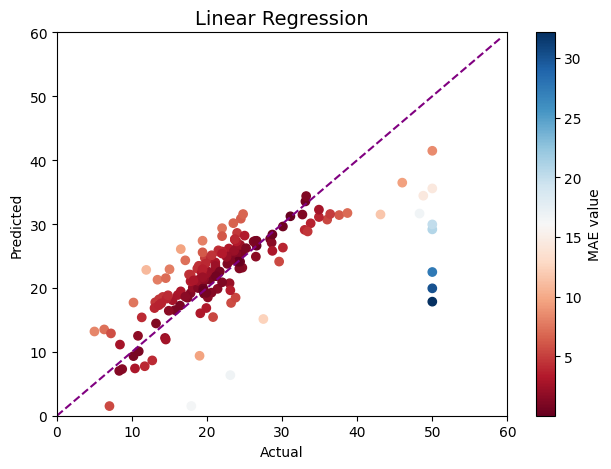

In [53]:
visualize_mean_absolute_error("Linear Regression", y_test, y_predicted)

***

## Задание*

Модель, построенная в предыдущем разделе решает задачу регрессии методом градиентного спуска.
Однако её так же можно решить методом наименьших квадратов.

Цель МНК — найти такие параметры модели (веса), которые минимизируют сумму квадратов разностей
между предсказанными и фактическими значениями целевой переменной. Рассмотрим математическую основу
метода.

### Постановка задачи
Пусть у нас есть:
- Матрица признаков $X$ размерности $n \times m$, где $n$ — количество наблюдений, $m$ — количество
признаков.
- Вектор целевой переменной $y$ размерности $n \times 1$.
- Вектор весов $w$ размерности $m \times 1$, который нужно найти.

Линейная модель предсказывает значения $\hat{y}$ как:

$$ \hat{y} = Xw, $$

где $\hat{y}$ — вектор предсказанных значений.

### Цель метода
Метод наименьших квадратов минимизирует функцию потерь (сумму квадратов ошибок):

$$ L(w) = \| y - Xw \|^2, $$

где:
- $y$ — фактическое значение целевой переменной,
- $Xw$ — предсказанное значение,
- $\| \cdot \|^2$ — квадрат евклидовой нормы (сумма квадратов разностей).

Реализуйте данный алгоритм, наследуя `BaseSolver`. Более предметно МНК можно изучить
[здесь](https://textbooks.math.gatech.edu/ila/least-squares.html).

In [8]:
class BaseSolver(ABC):
    """Abstract base solver class to be inherited by other solvers."""

    def __init__(self) -> None:
        self.coefficient_matrix: ndarray
        self.scalars_vector: ndarray
        self.augmented_matrix: ndarray
        self.solution_vector: ndarray

    @abstractmethod
    def fit(
        self, coefficient_matrix: ndarray, scalars_vector: ndarray, **kwargs
    ) -> None:
        """Abstract method for fitting the solver and validate the inputs."""
        self.coefficient_matrix, self.scalars_vector = (
            coefficient_matrix,
            scalars_vector,
        )
        self.augmented_matrix = np.concatenate(
            (self.coefficient_matrix, self.scalars_vector), axis=1
        )

    @abstractmethod
    def solve(self, *, round_to: Optional[int] = None) -> Any:
        """Abstract method for solving the system of linear equations."""
        message = "Every solver must implement the `solve()` method"
        raise NotImplementedError(message)

    def _apply_partial_pivoting(self, iteration: int, rows: int) -> ndarray:
        # Perform partial pivoting to avoid division by zero.
        for row in range(iteration + 1, rows):
            if np.abs(self.augmented_matrix[iteration, iteration]) < np.abs(
                self.augmented_matrix[row, iteration]
            ):
                self.augmented_matrix[[row, iteration]] = (
                    self.augmented_matrix[[iteration, row]]
                )

        if not self.augmented_matrix[iteration, iteration]:
            message = "Given system of linear equations is degenerate"
            raise ZeroDivisionError(message)
        return self.augmented_matrix


class LeastSquaresSolver(BaseSolver):
    """Least squares solver solves dependent systems of linear equations
    using Least Squares method.
    """

    def __init__(self):
        super().__init__()

    def fit(
        self, coefficient_matrix: ndarray, scalars_vector: ndarray, **kwargs
    ):
        """Perform computations to transform given matrices in appropriate for
        GaussianEliminationBaseSolver form.
        """
        ...

    def solve(self, *, round_to: Optional[int] = None):
        """Solve the transformed system of linear equations using Gaussian
        Elimination method.
        """
        ...

Пользуясь новым методом, расширьте функциональность класса `LinearRegression`.

In [9]:
class ExtendedLinearRegression(LinearRegression):
    def fit(
        self,
        x_train,
        y_train,
        *args,
        n_iterations=100,
        learning_rate=0.01,
        batch_size=100,
        random_seed=None,
        solve_algebraically: bool = False,
        **kwargs,
    ):
        super().fit(x_train, y_train, *args, **kwargs)
        if random_seed:
            np.random.seed(random_seed)

        if solve_algebraically:
            round_to = (
                kwargs.get("round_to")
                if kwargs.get("round_to") is not None
                else 10
            )
            self._solve_algebraicaly(round_to)
            return

        return super().fit(
            x_train,
            y_train,
            *args,
            n_iterations=n_iterations,
            learning_rate=learning_rate,
            batch_size=batch_size,
            random_seed=random_seed,
            **kwargs,
        )

    def _solve_algebraicaly(self, round_to: int) -> None:
        solver = LeastSquaresSolver()
        ...
        weights = solver.solve(round_to=round_to)

        self.weights_map_ = {"weights": weights, "bias": 0.0}

После решения задачи, посмотрите, как данный алгоритм справится с той же задачей о ценах на
жильё.

In [ ]:
linear_regressor = ExtendedLinearRegression()
linear_regressor.fit(x_train, y_train, solve_algebraically=True)

y_predicted = linear_regressor.predict(x_test)
mae = compute_mean_absolute_error(y_test, y_predicted)
print(f"MAE: {mae}")